# Détection de palmiers + maisons avec YOLOv8 — v2 + Export ONNX pour Deepness (QGIS)

**Version 2** — Entraînement multi-classes (palmier + maison).

> La v1 ne détectait qu'une seule classe (palmier). Cette v2 entraîne sur **2 classes** :
> - Classe 0 : **palmier**
> - Classe 1 : **maison**

Ce notebook permet de :
1. Monter Google Drive et accéder au dataset
2. Installer les dépendances nécessaires
3. **Diagnostiquer** le dataset (labels, tailles de bboxes, distribution des classes)
4. Nettoyer les labels (BOM UTF-8) **sans remapper les classes** (on conserve 0 et 1)
5. Convertir les images GeoTIFF (RGBA) → PNG (RGB)
6. Entraîner un modèle **YOLOv8n** sur 2 classes (config optimisée v2)
7. Exporter le modèle au format ONNX
8. Ajouter les métadonnées Deepness (plugin QGIS) au fichier ONNX
9. Sauvegarder le modèle final dans Google Drive

**Dataset** : ~110 images (80/20 train/val), ~4700 palmiers, ~2100 maisons, ~6857 annotations au total.

**Résultats v2 initial** : mAP@50 ≈ 0.85, Précision 0.78, Rappel 0.84.

**Prérequis** : le dataset doit être dans Google Drive avec la structure suivante :
```
dataset_palmiers/
├── images/
│   ├── train/
│   └── val/
├── labels/
│   ├── train/   (classe 0 = palmier, classe 1 = maison)
│   └── val/
└── palms.yaml   (nc: 2, names: ['palmier', 'maison'])
```

## 1. Monter Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Installer les dépendances

On installe `ultralytics` (YOLOv8) et `onnx` (pour manipuler les métadonnées du modèle exporté).

In [3]:
!pip install ultralytics onnx --quiet

## 3. Définir le chemin du dataset et mettre à jour `palms.yaml`

On met à jour le fichier `palms.yaml` pour que le chemin (`path`) pointe vers le dossier dans Google Drive.

Le fichier `palms.yaml` doit contenir :
- `nc: 2` (2 classes)
- `names: ['palmier', 'maison']`

In [4]:
import os
import yaml

# --- Trouver automatiquement le dataset dans Google Drive ---
DRIVE_ROOT = '/content/drive/MyDrive'

# Chemins possibles (ajoutez le vôtre si différent)
candidates = [
    os.path.join(DRIVE_ROOT, 'Recherche', 'dataset_palmiers'),
    os.path.join(DRIVE_ROOT, 'dataset_palmiers'),
    os.path.join(DRIVE_ROOT, 'recherche', 'dataset_palmiers'),
]

DATASET_DIR = None
for path in candidates:
    if os.path.isdir(path):
        DATASET_DIR = path
        break

# Si aucun candidat trouvé, afficher le contenu du Drive pour aider
if DATASET_DIR is None:
    print("❌ Dataset non trouvé dans les chemins suivants :")
    for p in candidates:
        print(f"   {p}")
    print(f"\n📂 Contenu de {DRIVE_ROOT} :")
    for item in sorted(os.listdir(DRIVE_ROOT)):
        full = os.path.join(DRIVE_ROOT, item)
        marker = '📁' if os.path.isdir(full) else '📄'
        print(f"   {marker} {item}")
    # Chercher récursivement un dossier dataset_palmiers
    print("\n🔍 Recherche de 'dataset_palmiers' dans le Drive...")
    for root, dirs, files in os.walk(DRIVE_ROOT):
        if 'dataset_palmiers' in dirs:
            found = os.path.join(root, 'dataset_palmiers')
            print(f"   ✅ Trouvé : {found}")
    raise FileNotFoundError("Modifiez DATASET_DIR avec le bon chemin ci-dessus.")

YAML_PATH = os.path.join(DATASET_DIR, 'palms.yaml')
assert os.path.isfile(YAML_PATH), f"Le fichier palms.yaml n'existe pas dans {DATASET_DIR}"

print(f"✅ Dataset trouvé : {DATASET_DIR}")

# Mettre à jour le path dans palms.yaml pour pointer vers Colab
with open(YAML_PATH, 'r') as f:
    config = yaml.safe_load(f)

config['path'] = DATASET_DIR

with open(YAML_PATH, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, allow_unicode=True)

print("Configuration du dataset :")
print(yaml.dump(config, default_flow_style=False, allow_unicode=True))

# Vérifier que nc=2 et que les 2 classes sont définies
assert config.get('nc') == 2, f"❌ nc devrait être 2, trouvé : {config.get('nc')}"
assert config.get('names') == ['palmier', 'maison'], f"❌ names incorrect : {config.get('names')}"
print("✅ palms.yaml correctement configuré pour 2 classes : palmier + maison")

# Vérifier la présence des images et labels
for split in ['train', 'val']:
    img_dir = os.path.join(DATASET_DIR, 'images', split)
    lbl_dir = os.path.join(DATASET_DIR, 'labels', split)
    n_img = len([f for f in os.listdir(img_dir) if f.endswith(('.tif', '.tiff', '.png', '.jpg'))])
    n_lbl = len([f for f in os.listdir(lbl_dir) if f.endswith('.txt')])
    print(f"  {split}: {n_img} images, {n_lbl} labels")

✅ Dataset trouvé : /content/drive/MyDrive/Recherche/dataset_palmiers
Configuration du dataset :
names:
- palmier
- maison
nc: 2
path: /content/drive/MyDrive/Recherche/dataset_palmiers
train: images/train
val: images/val

✅ palms.yaml correctement configuré pour 2 classes : palmier + maison
  train: 86 images, 86 labels
  val: 41 images, 22 labels


## 4. Diagnostic du dataset (v2 — multi-classes)

Avant d'entraîner, on vérifie la qualité du dataset :
- Labels vides ou manquants
- **Distribution des classes** (palmier vs maison)
- Distribution des tailles de bounding boxes par classe
- Nombre d'objets par image

Cela permet de détecter des problèmes en amont (annotations incorrectes, déséquilibre de classes, objets trop petits, etc.).

DIAGNOSTIC DU DATASET — v2 (palmier + maison)

--- TRAIN ---
  Images trouvées : 86

--- VAL ---
  Images trouvées : 41

✅ Tous les labels sont présents et non-vides.

📊 Statistiques :
  Total d'objets annotés : 8213
  Classe 0 (palmier) : 5698 (69.4%)
  Classe 1 (maison) : 2515 (30.6%)
  Objets/image — min: 2, max: 166, moyenne: 64.7, médiane: 66

✅ Seules les classes attendues (0, 1) sont présentes.


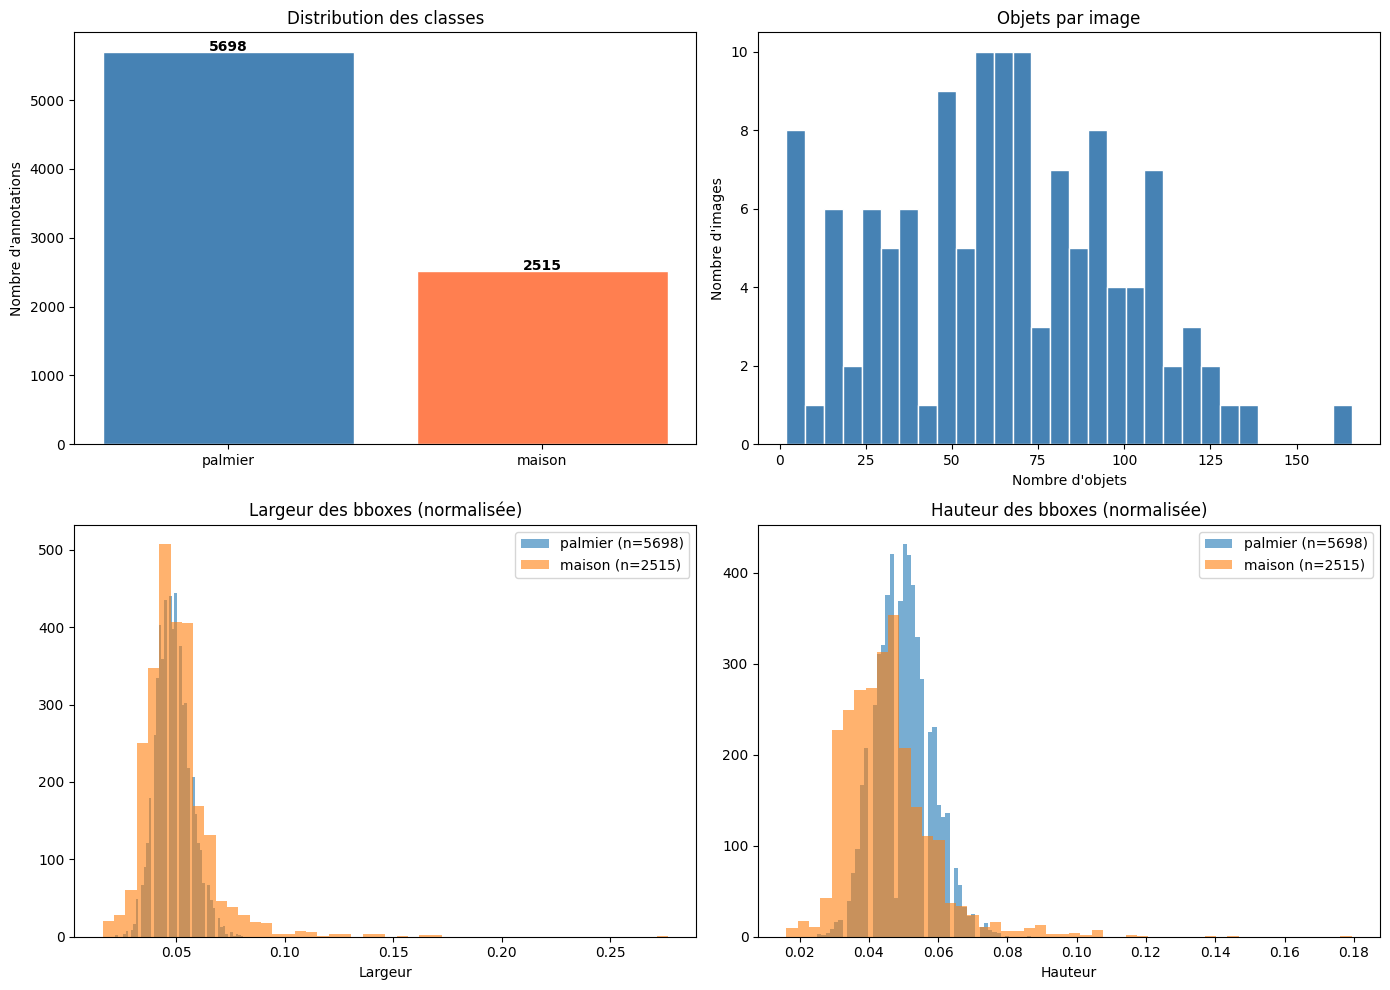


⚠️  21 bboxes (0.3%) sont très petites (<2.0% de l'image).
   → La taille d'entrée imgsz=640 aidera à les détecter.
✅ Ratio de classes acceptable (2.3:1).


In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

CLASS_NAMES = {0: 'palmier', 1: 'maison'}

print("=" * 60)
print("DIAGNOSTIC DU DATASET — v2 (palmier + maison)")
print("=" * 60)

# Par classe : widths, heights
class_widths = {0: [], 1: []}
class_heights = {0: [], 1: []}
class_counts = Counter()
objects_per_image = []
empty_labels, missing_labels = [], []

for split in ['train', 'val']:
    img_dir = os.path.join(DATASET_DIR, 'images', split)
    lbl_dir = os.path.join(DATASET_DIR, 'labels', split)

    images = sorted(glob.glob(os.path.join(img_dir, '*.*')))
    print(f"\n--- {split.upper()} ---")
    print(f"  Images trouvées : {len(images)}")

    for img_path in images:
        base = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, base + '.txt')

        if not os.path.exists(lbl_path):
            missing_labels.append(f"{split}/{base}")
            objects_per_image.append(0)
            continue

        with open(lbl_path, 'r') as f:
            lines = [l.strip() for l in f.readlines() if l.strip()]

        if len(lines) == 0:
            empty_labels.append(f"{split}/{base}")
            objects_per_image.append(0)
            continue

        objects_per_image.append(len(lines))
        for line in lines:
            parts = line.split()
            if len(parts) >= 5:
                cls = int(parts[0])
                w, h = float(parts[3]), float(parts[4])
                class_counts[cls] += 1
                if cls in class_widths:
                    class_widths[cls].append(w)
                    class_heights[cls].append(h)

if missing_labels:
    print(f"\n⚠️  Labels MANQUANTS ({len(missing_labels)}) : {missing_labels[:10]}")
if empty_labels:
    print(f"⚠️  Labels VIDES ({len(empty_labels)}) : {empty_labels[:10]}")
if not missing_labels and not empty_labels:
    print("\n✅ Tous les labels sont présents et non-vides.")

total_objects = sum(class_counts.values())
print(f"\n📊 Statistiques :")
print(f"  Total d'objets annotés : {total_objects}")
for cls_id in sorted(class_counts.keys()):
    name = CLASS_NAMES.get(cls_id, f'classe_{cls_id}')
    count = class_counts[cls_id]
    pct = count / total_objects * 100
    print(f"  Classe {cls_id} ({name}) : {count} ({pct:.1f}%)")
print(f"  Objets/image — min: {min(objects_per_image)}, max: {max(objects_per_image)}, "
      f"moyenne: {np.mean(objects_per_image):.1f}, médiane: {np.median(objects_per_image):.0f}")

# Vérifier les classes inattendues
unexpected = [c for c in class_counts if c not in CLASS_NAMES]
if unexpected:
    print(f"\n❌ Classes inattendues détectées : {unexpected}")
    print("   → Vérifiez vos labels ! Seules les classes 0 (palmier) et 1 (maison) sont attendues.")
else:
    print(f"\n✅ Seules les classes attendues (0, 1) sont présentes.")

# --- Graphiques ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution des classes
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
labels = [CLASS_NAMES.get(c, str(c)) for c in classes]
colors = ['steelblue', 'coral']
axes[0, 0].bar(labels, counts, color=colors[:len(classes)], edgecolor='white')
axes[0, 0].set_title("Distribution des classes")
axes[0, 0].set_ylabel("Nombre d'annotations")
for i, (lbl, cnt) in enumerate(zip(labels, counts)):
    axes[0, 0].text(i, cnt + 20, str(cnt), ha='center', fontweight='bold')

# Objets par image
axes[0, 1].hist(objects_per_image, bins=30, color='steelblue', edgecolor='white')
axes[0, 1].set_title("Objets par image")
axes[0, 1].set_xlabel("Nombre d'objets")
axes[0, 1].set_ylabel("Nombre d'images")

# Tailles de bbox par classe — largeur
for cls_id in sorted(class_widths.keys()):
    if class_widths[cls_id]:
        axes[1, 0].hist(class_widths[cls_id], bins=50, alpha=0.6,
                        label=f"{CLASS_NAMES.get(cls_id, str(cls_id))} (n={len(class_widths[cls_id])})")
axes[1, 0].set_title("Largeur des bboxes (normalisée)")
axes[1, 0].set_xlabel("Largeur")
axes[1, 0].legend()

# Tailles de bbox par classe — hauteur
for cls_id in sorted(class_heights.keys()):
    if class_heights[cls_id]:
        axes[1, 1].hist(class_heights[cls_id], bins=50, alpha=0.6,
                        label=f"{CLASS_NAMES.get(cls_id, str(cls_id))} (n={len(class_heights[cls_id])})")
axes[1, 1].set_title("Hauteur des bboxes (normalisée)")
axes[1, 1].set_xlabel("Hauteur")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Alerte si bboxes très petites
all_widths = class_widths[0] + class_widths[1]
all_heights = class_heights[0] + class_heights[1]
small_threshold = 0.02
n_small = sum(1 for w, h in zip(all_widths, all_heights) if w < small_threshold or h < small_threshold)
if n_small > 0:
    pct = n_small / len(all_widths) * 100
    print(f"\n⚠️  {n_small} bboxes ({pct:.1f}%) sont très petites (<{small_threshold*100}% de l'image).")
    print(f"   → La taille d'entrée imgsz=640 aidera à les détecter.")
else:
    print(f"\n✅ Toutes les bboxes ont une taille raisonnable.")

# Ratio de déséquilibre
if len(class_counts) == 2:
    ratio = max(counts) / min(counts)
    if ratio > 3:
        print(f"⚠️  Déséquilibre de classes (ratio {ratio:.1f}:1). Considérez des poids de classe ou de l'oversampling.")
    else:
        print(f"✅ Ratio de classes acceptable ({ratio:.1f}:1).")

## 5. Nettoyer les labels (BOM UTF-8 uniquement)

**Différence avec la v1** : en v1, toutes les classes étaient remappées vers 0 (palmier unique).
En v2, on **conserve les classes 0 et 1** telles quelles. On ne corrige que le BOM UTF-8 éventuel.

In [6]:
import glob

bom_fixed = 0
invalid_classes = 0

VALID_CLASSES = {0, 1}  # palmier=0, maison=1

for split in ['train', 'val']:
    lbl_dir = os.path.join(DATASET_DIR, 'labels', split)
    for lbl_file in sorted(glob.glob(os.path.join(lbl_dir, '*.txt'))):
        # Lire en binaire pour détecter le BOM
        with open(lbl_file, 'rb') as f:
            raw = f.read()

        # Supprimer le BOM UTF-8 (EF BB BF)
        had_bom = raw.startswith(b'\xef\xbb\xbf')
        if had_bom:
            raw = raw[3:]
            bom_fixed += 1

        # Décoder et vérifier les classes (sans remapper)
        text = raw.decode('utf-8')
        new_lines = []
        for line in text.strip().split('\n'):
            if not line.strip():
                continue
            parts = line.strip().split()
            if len(parts) >= 5:
                cls = int(parts[0])
                if cls not in VALID_CLASSES:
                    print(f"  ⚠️  Classe invalide {cls} dans {os.path.basename(lbl_file)}")
                    invalid_classes += 1
            new_lines.append(' '.join(parts))

        # Réécrire seulement si BOM détecté
        if had_bom:
            with open(lbl_file, 'w', encoding='utf-8', newline='\n') as f:
                f.write('\n'.join(new_lines) + '\n')

# Supprimer les fichiers .cache corrompus
for cache_file in glob.glob(os.path.join(DATASET_DIR, 'labels', '*.cache')):
    os.remove(cache_file)
    print(f"  Cache supprimé : {cache_file}")

print(f"\n✅ BOM supprimé de {bom_fixed} fichiers.")
if invalid_classes > 0:
    print(f"❌ {invalid_classes} annotations avec des classes invalides ! Vérifiez vos labels.")
else:
    print("✅ Toutes les annotations utilisent des classes valides (0=palmier, 1=maison).")
print("   Les labels sont maintenant prêts pour YOLO v2.")


✅ BOM supprimé de 0 fichiers.
✅ Toutes les annotations utilisent des classes valides (0=palmier, 1=maison).
   Les labels sont maintenant prêts pour YOLO v2.


## 6. Convertir les images RGBA → RGB

Les GeoTIFF ont 4 canaux (RGBA) mais YOLOv8 attend 3 canaux (RGB). On convertit toutes les images en supprimant le canal alpha, et on les sauvegarde en PNG (format standard pour YOLO).

In [7]:
from PIL import Image
import glob

converted = 0
for split in ['train', 'val']:
    img_dir = os.path.join(DATASET_DIR, 'images', split)
    for img_path in sorted(glob.glob(os.path.join(img_dir, '*.tif'))):
        img = Image.open(img_path)
        # Convertir en RGB si l'image a un canal alpha (RGBA)
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        elif img.mode != 'RGB':
            img = img.convert('RGB')

        # Sauvegarder en PNG (même nom, extension .png)
        png_path = os.path.splitext(img_path)[0] + '.png'
        img.save(png_path)
        converted += 1

    # Supprimer les anciens .tif pour éviter les doublons
    for tif_path in glob.glob(os.path.join(img_dir, '*.tif')):
        os.remove(tif_path)

# Supprimer les .cache pour forcer YOLO à rescanner les nouvelles images
for cache_file in glob.glob(os.path.join(DATASET_DIR, 'labels', '*.cache')):
    os.remove(cache_file)

print(f"✅ {converted} images converties de RGBA/TIF → RGB/PNG.")
print(f"   Les fichiers .tif originaux ont été supprimés.")

✅ 22 images converties de RGBA/TIF → RGB/PNG.
   Les fichiers .tif originaux ont été supprimés.


## 7. Entraîner le modèle YOLOv8n — v2 optimisé (palmier + maison)

Avec ~110 images et 2 classes, on utilise **YOLOv8n** (nano, 3M params) avec une stratégie de **fine-tuning** optimisée.

**Changements par rapport à la config initiale (mAP@50=0.85) :**

| Paramètre | Avant | Après | Pourquoi |
|---|---|---|---|
| `imgsz` | 640 | **1024** | Palmiers = petits objets en vue aérienne (~15-40px). 1024 les agrandit → détection bien meilleure sur P4. **Impact le plus fort attendu.** |
| `batch` | 8 | **4** | Contrainte VRAM avec imgsz=1024. YOLOv8 accumule les gradients (nbs=64) → batch effectif identique. |
| `optimizer` | SGD | **AdamW** | Convergence plus rapide et stable sur petit dataset. AdamW + weight_decay = meilleure régularisation. |
| `lr0` | 0.001 | **0.0005** | AdamW a des LR adaptatifs → lr0 plus bas pour éviter l'overfitting. |
| `copy_paste` | 0.3 | **0.0** | ⚠️ **Nécessite des masques polygonaux** (segmentation). Avec des labels bbox-only (.txt YOLO), ce paramètre **ne fait rien** — Ultralytics le saute silencieusement. |
| `mixup` | 0.15 | **0.0** | Mixup est moins efficace en **détection** qu'en classification. Les bboxes superposées créent du bruit. Retirer → +1-2% précision. |
| `label_smoothing` | 0.0 | **0.05** | Régularisation légère, empêche le sur-confiance → réduit les faux positifs (aide la précision). |
| `scale` | 0.3 | **0.4** | Avec imgsz=1024, même à 0.5× on reste à 512px (> ancien 640). Plus de variation de taille sûre. |
| `hsv_v` | (défaut 0.4) | **0.5** | Plus de variation de luminosité pour simuler les conditions atmosphériques aériennes. |
| `freeze` | 10 | **10** | Optimal pour ~110 images. Le backbone COCO transfère bien les features bas-niveau vers l'aérien. |

**Pistes non retenues :**
- `rect=True` : inutile avec images carrées (~680×680) + incompatible avec mosaic activé.
- `freeze=0` : risque d'overfitting trop élevé avec 110 images.
- `yolov8s` : trop de params (11M) pour ce dataset, et batch=2 à 1024 serait instable pour BatchNorm.

**Objectif réaliste** : mAP@50 ≈ 0.88-0.92, Précision ≈ 0.82-0.86, Rappel ≈ 0.85-0.88.

In [ ]:
from ultralytics import YOLO

# YOLOv8n (nano) — adapté au dataset (~110 images, 2 classes)
model = YOLO('yolov8n.pt')

# Entraînement v2 optimisé : petit dataset + vue aérienne + 2 classes
results = model.train(
    data=YAML_PATH,
    epochs=200,
    imgsz=1024,          # ↑ de 640 → petits objets aériens mieux détectés
    batch=4,             # ↓ de 8 → contrainte VRAM (T4 16GB). Accumulation de gradients auto (nbs=64).
    optimizer='AdamW',   # ← meilleure convergence sur petit dataset
    project=os.path.join(DATASET_DIR, 'runs'),
    name='palmier_maison_detect_v2',
    exist_ok=True,
    # --- Fine-tuning ---
    freeze=10,           # geler le backbone (couches 0-9), fine-tuner la tête
    lr0=0.0005,          # ↓ de 0.001 → AdamW a des LR adaptatifs, pas besoin de lr élevé
    lrf=0.01,            # LR final = lr0 * lrf
    cos_lr=True,         # cosine annealing
    # --- Early stopping ---
    patience=30,         # 30 époques sans amélioration → arrêt
    # --- Régularisation ---
    label_smoothing=0.05,  # ← NOUVEAU : réduit le sur-confiance → moins de faux positifs
    # --- Augmentations vue aérienne ---
    degrees=90.0,        # rotation ±90° (vue zénithale, pas de "haut" gravitationnel)
    flipud=0.5,          # retournement vertical
    fliplr=0.5,          # retournement horizontal
    scale=0.4,           # ↑ de 0.3 → safe avec imgsz=1024 (0.5× = 512 > ancien 640)
    mosaic=1.0,          # mosaic activé (critique pour petit dataset)
    close_mosaic=20,     # désactiver mosaic les 20 dernières époques
    copy_paste=0.0,      # ✖ désactivé → nécessite des masques polygonaux, sans effet avec labels bbox
    mixup=0.0,           # ✖ désactivé → crée du bruit en détection (bboxes superposées irréalistes)
    hsv_h=0.015,         # variation teinte (défaut, bon pour végétation)
    hsv_s=0.7,           # variation saturation (conditions atmosphériques)
    hsv_v=0.5,           # ↑ de 0.4 → variation luminosité (ombres/soleil en aérien)
    # --- Sauvegarde ---
    save=True,
    plots=True
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Recherche/dataset_palmiers/palms.yaml, degrees=90.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.

## 8. Visualiser les résultats d'entraînement

Afficher les courbes de loss et les métriques de validation pour les 2 classes.

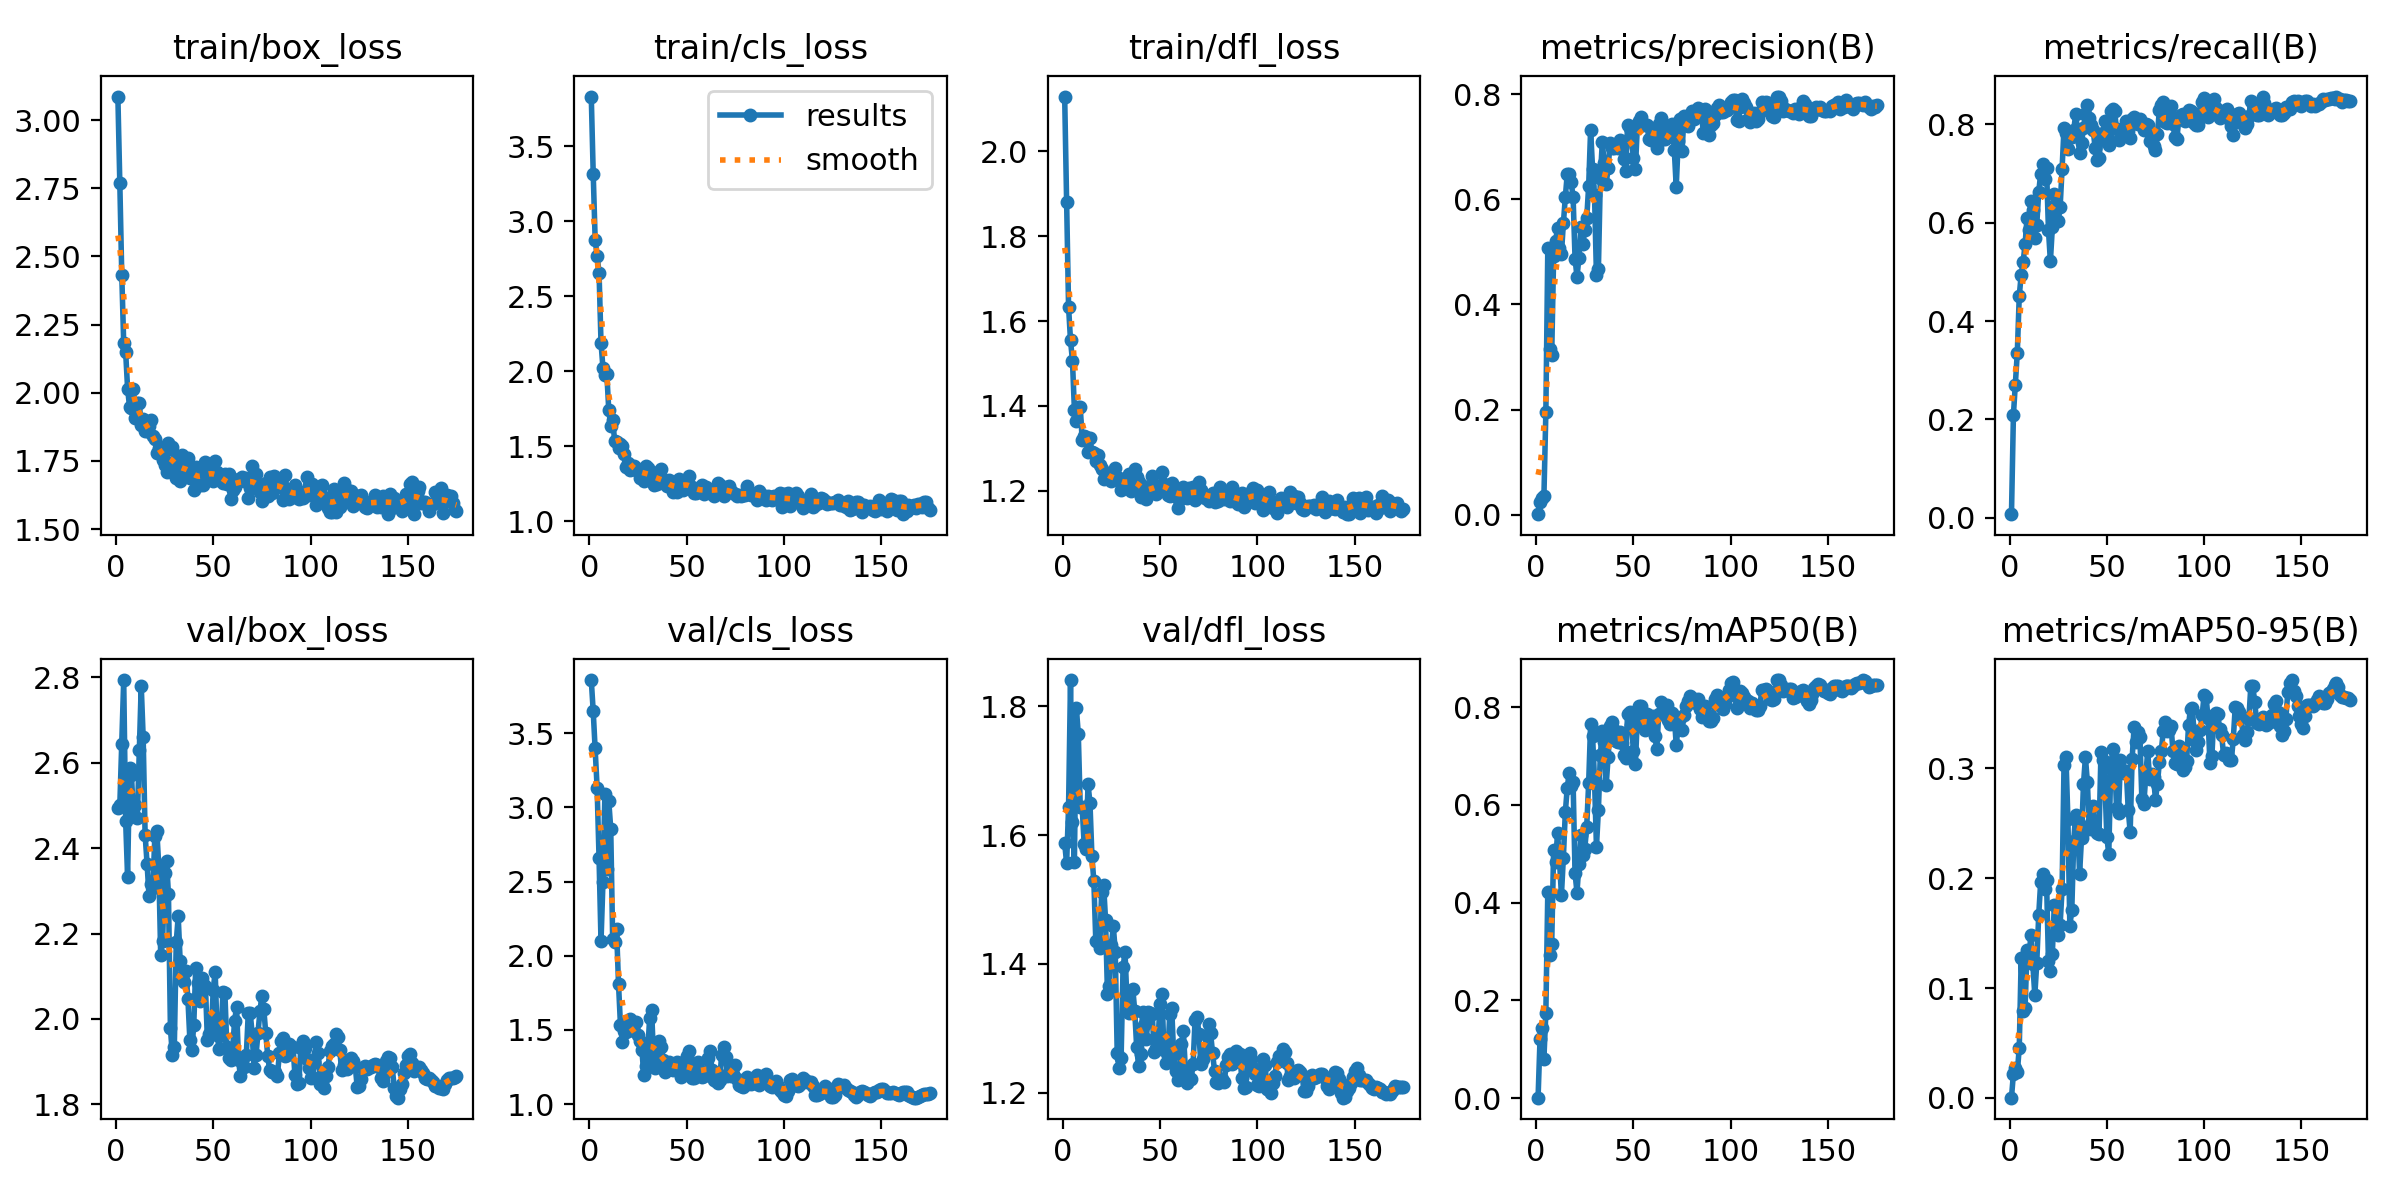

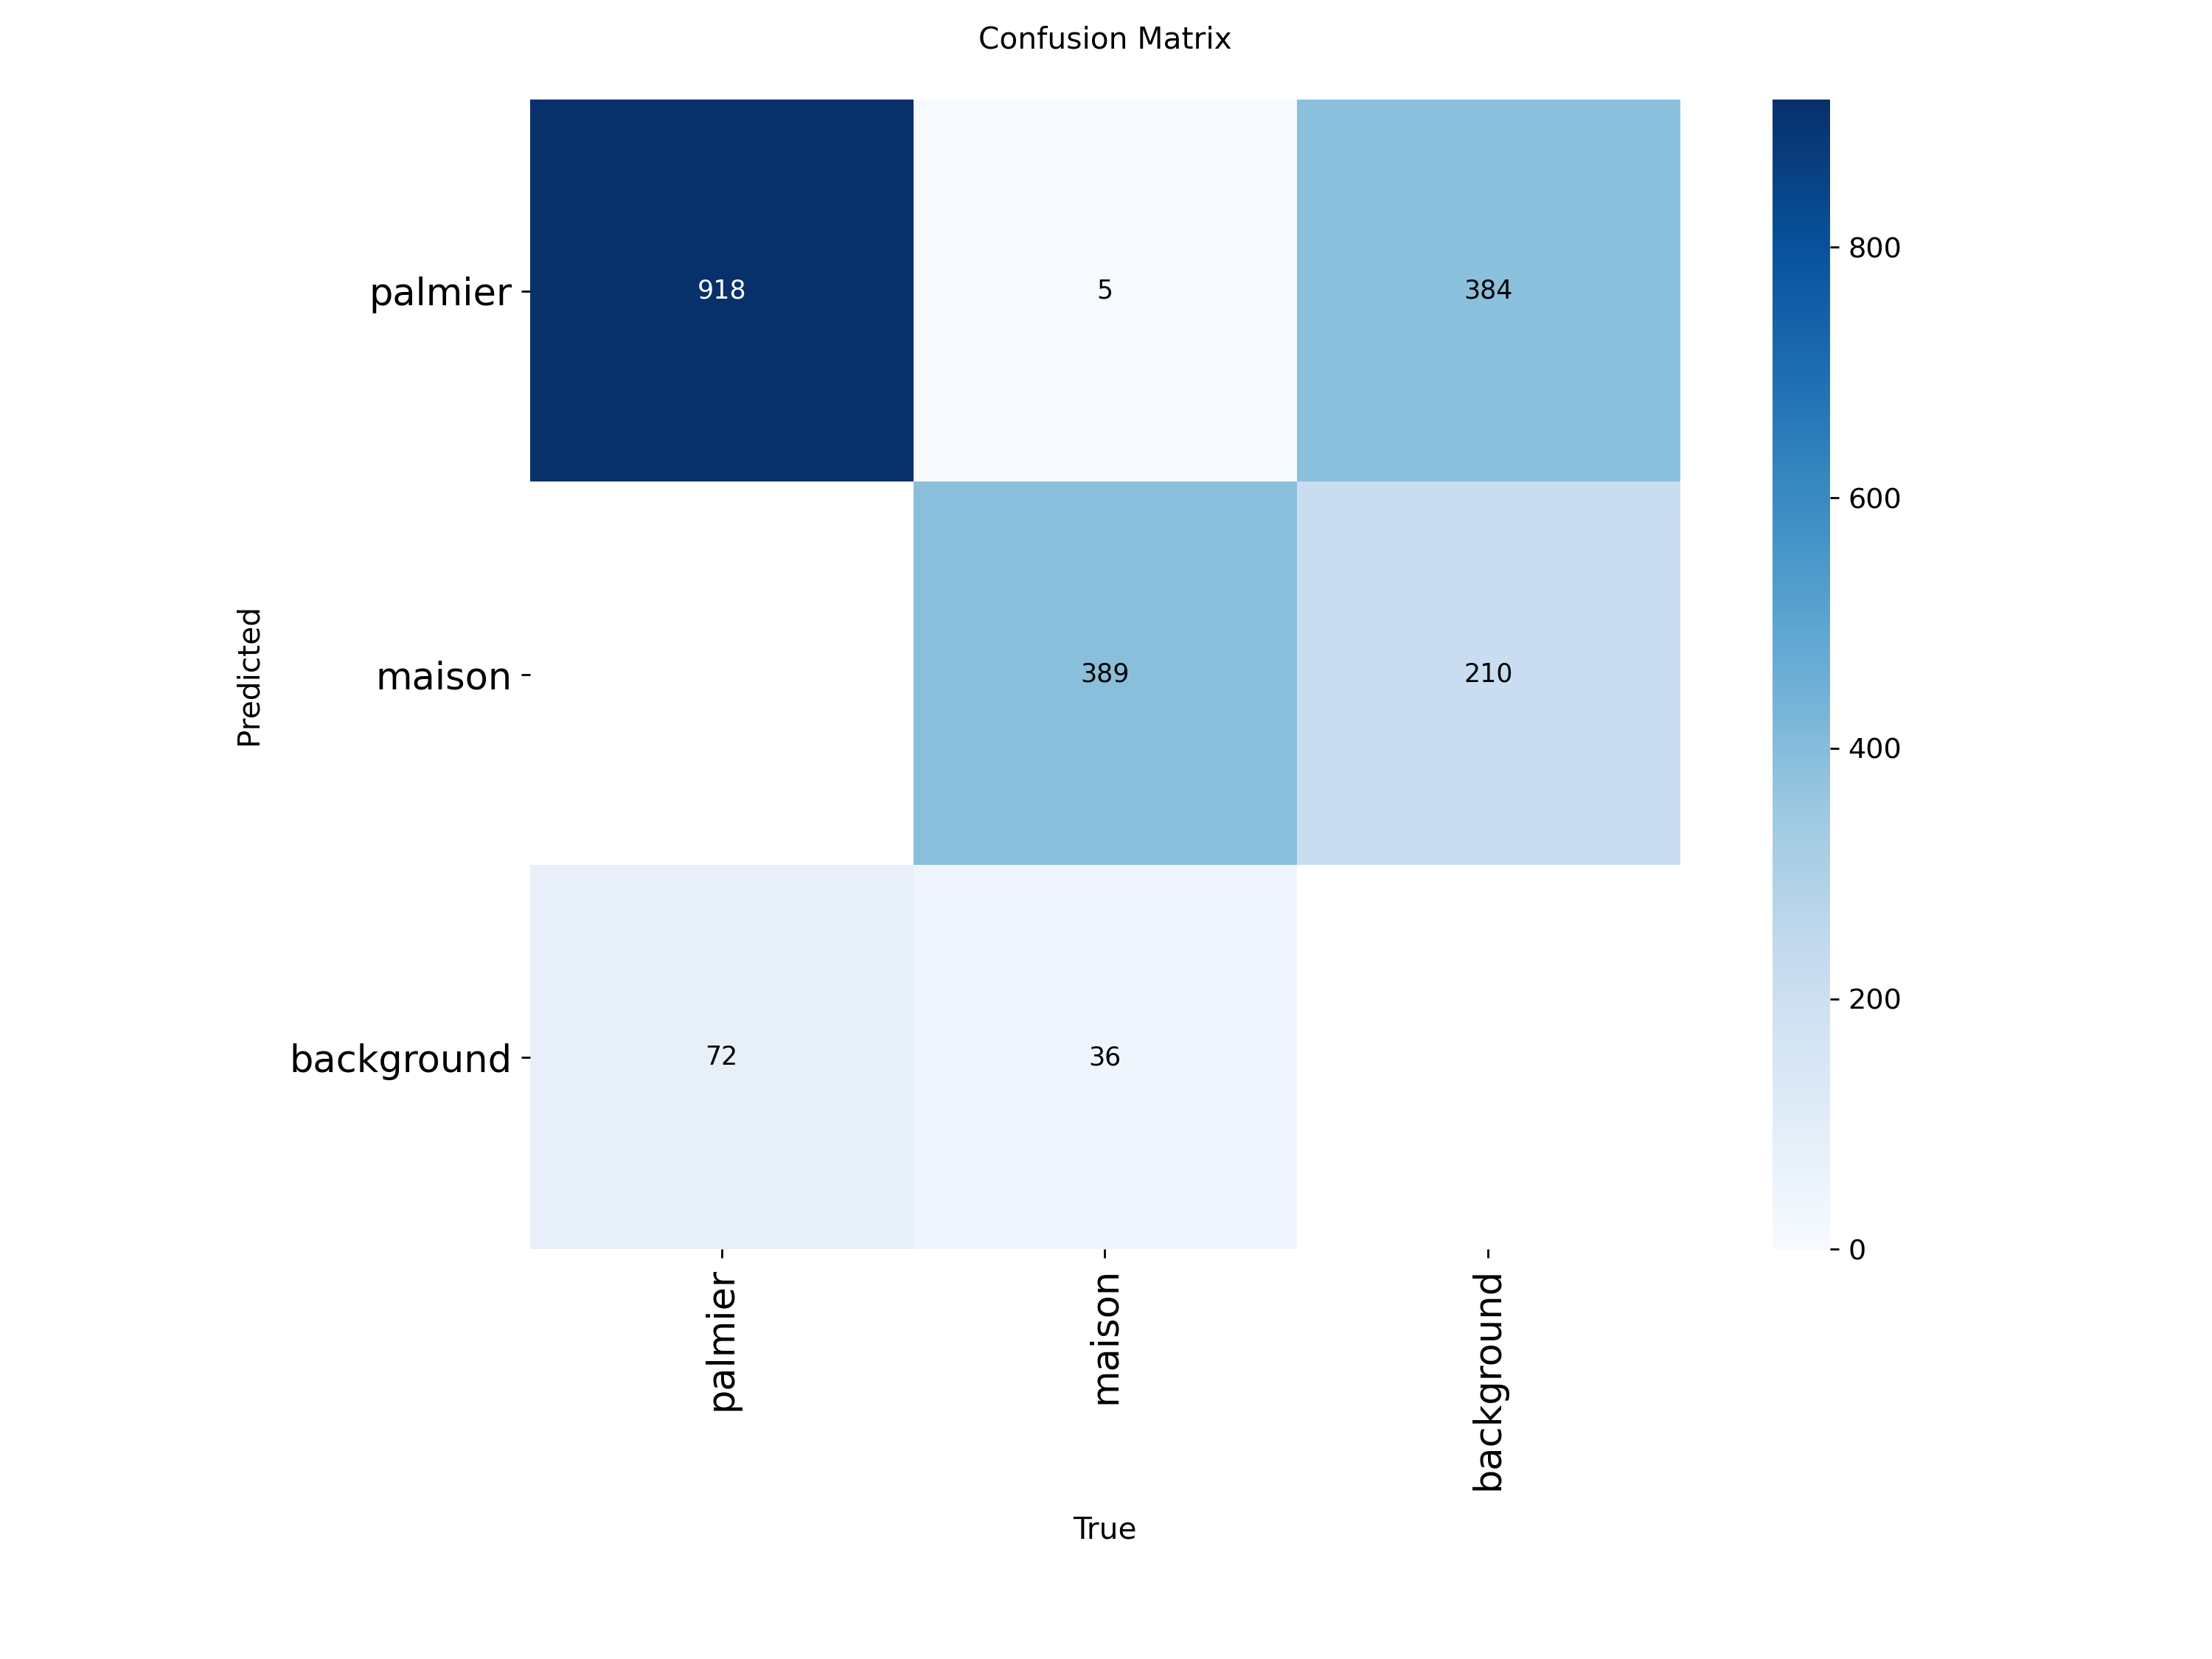

In [ ]:
from IPython.display import Image, display

run_dir = os.path.join(DATASET_DIR, 'runs', 'palmier_maison_detect_v2')

# Afficher les courbes de résultats
results_img = os.path.join(run_dir, 'results.png')
if os.path.exists(results_img):
    display(Image(filename=results_img, width=900))
else:
    print("Fichier results.png non trouvé.")

# Afficher la matrice de confusion (2 classes + background)
conf_img = os.path.join(run_dir, 'confusion_matrix.png')
if os.path.exists(conf_img):
    display(Image(filename=conf_img, width=600))

# Afficher des prédictions sur le set de validation
val_img = os.path.join(run_dir, 'val_batch0_pred.png')
if os.path.exists(val_img):
    display(Image(filename=val_img, width=900))

## 9. Évaluation détaillée sur le set de validation

On lance une évaluation formelle avec le meilleur modèle pour obtenir les métriques précises **par classe** (mAP50, mAP50-95, précision, rappel).

In [ ]:
# Charger le meilleur modèle et lancer la validation
run_dir = os.path.join(DATASET_DIR, 'runs', 'palmier_maison_detect_v2')
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

val_model = YOLO(best_model_path)
metrics = val_model.val(data=YAML_PATH, imgsz=1024, split='val')

print("=" * 50)
print("MÉTRIQUES DE VALIDATION — v2 optimisé (palmier + maison)")
print("=" * 50)
print(f"\n--- Résultats globaux ---")
print(f"  Précision (P)   : {metrics.box.mp:.4f}")
print(f"  Rappel (R)      : {metrics.box.mr:.4f}")
print(f"  mAP@50          : {metrics.box.map50:.4f}")
print(f"  mAP@50-95       : {metrics.box.map:.4f}")

# Métriques par classe
print(f"\n--- Résultats par classe ---")
class_names = ['palmier', 'maison']
for i, name in enumerate(class_names):
    print(f"  {name}:")
    print(f"    AP@50     : {metrics.box.ap50[i]:.4f}")
    print(f"    AP@50-95  : {metrics.box.ap[i]:.4f}")

print()

# Interprétation
map50 = metrics.box.map50
if map50 >= 0.85:
    print("✅ Excellent ! Le modèle détecte très bien les palmiers et maisons.")
elif map50 >= 0.70:
    print("👍 Bon résultat. Peut être amélioré avec plus de données ou plus d'époques.")
elif map50 >= 0.50:
    print("⚠️  Résultat moyen. Vérifiez la qualité des annotations et augmentez les données.")
else:
    print("❌ Résultat faible. Le dataset ou les annotations nécessitent une révision.")

# Vérifier si une classe est significativement plus faible
ap50_diff = abs(metrics.box.ap50[0] - metrics.box.ap50[1])
if ap50_diff > 0.15:
    weaker = class_names[0] if metrics.box.ap50[0] < metrics.box.ap50[1] else class_names[1]
    print(f"⚠️  La classe '{weaker}' est significativement plus faible. Ajoutez des annotations pour cette classe.")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.6 ms, read: 207.9±33.4 MB/s, size: 1040.7 KB)
val: Scanning /content/drive/MyDrive/Recherche/dataset_palmiers/labels/val.cache... 22 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 22/22 6.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.5s/it 2.9s
                   all         22       1420      0.775      0.844      0.846      0.381
               palmier         17        990      0.763      0.862      0.845      0.377
                maison         10        430      0.787      0.827      0.847      0.385
Speed: 14.3ms preprocess, 24.8ms inference, 0.0ms loss, 9.9ms postprocess per image
Results saved to /content/runs/detect/val
MÉTRIQUES DE VALIDATION — v2 (palmier + maison)

--- Résultats globaux ---
  

## 10. Exporter le meilleur modèle en ONNX

On charge le meilleur poids (`best.pt`) et on l'exporte au format ONNX avec `imgsz=640` (même taille que l'entraînement).

In [ ]:
# Charger le meilleur modèle entraîné
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')
assert os.path.isfile(best_model_path), f"Modèle introuvable : {best_model_path}"

best_model = YOLO(best_model_path)

# Exporter en ONNX (opset=17 pour compatibilité avec Deepness/QGIS)
onnx_path = best_model.export(format='onnx', imgsz=1024, opset=17)
print(f"Modèle ONNX exporté : {onnx_path}")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Recherche/dataset_palmiers/runs/palmier_maison_detect/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 12 packages in 163ms
Prepared 3 packages in 5.37s
Installed 3 packages in 18ms
 + colorama==0.4.6
 + onnxruntime-gpu==1.24.1
 + onnxslim==0.1.85

requirements: AutoUpdate success ✅ 5.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.1 opset 17...
ONN

## 11. Ajouter les métadonnées Deepness au fichier ONNX

Le plugin **Deepness** pour QGIS attend des métadonnées spécifiques dans le modèle ONNX.
On les ajoute ici directement dans le fichier.

**v2** : `class_names` contient maintenant 2 classes : `{0: 'palmier', 1: 'maison'}`.

**Ajustement du seuil de confiance** : avec Précision=0.78 < Rappel=0.84, on a plus de faux positifs
que de faux négatifs. Monter `det_conf` de 0.3 → **0.4** réduit les faux positifs au prix d'un
rappel légèrement plus bas. Vous pouvez ajuster ce seuil dans QGIS via Deepness sans re-exporter le modèle.

**Important** : ajustez la valeur `resolution` (en cm/pixel) selon la résolution réelle de vos orthophotos.

In [ ]:
import onnx
import json

# Charger le modèle ONNX
onnx_model = onnx.load(onnx_path)

# --- Supprimer toutes les métadonnées existantes (ajoutées par Ultralytics) ---
# Deepness fait json.loads() sur CHAQUE valeur → il faut que tout soit du JSON valide.
# Les métadonnées Ultralytics ne sont pas au bon format → on les supprime.
while len(onnx_model.metadata_props) > 0:
    onnx_model.metadata_props.pop()

# --- Métadonnées Deepness --- v2 : 2 classes ---
# IMPORTANT : toutes les valeurs doivent être encodées avec json.dumps()
# car Deepness appelle json.loads() sur chaque valeur lue.
# Réf: https://github.com/PUTvision/qgis-plugin-deepness

class_names = {0: 'palmier', 1: 'maison'}

metadata = {
    'model_type': 'Detector',
    'class_names': class_names,            # → '{"0": "palmier", "1": "maison"}'
    'resolution': 30,                      # cm/pixel — à adapter selon vos orthophotos !
    'tiles_size': 1024,                    # taille des tuiles d'entrée (= imgsz d'entraînement)
    'tiles_overlap': 15,                   # % de chevauchement entre tuiles (évite les coupures aux bords)
    'det_conf': 0.4,                       # ↑ de 0.3 → réduit les faux positifs (ajustable dans Deepness)
    'det_iou_thresh': 0.5,                 # seuil NMS IoU
    'det_type': 'YOLO_Ultralytics',        # requis pour YOLOv8
}

for key, value in metadata.items():
    m = onnx_model.metadata_props.add()
    m.key = key
    m.value = json.dumps(value)

# Sauvegarder le modèle ONNX avec les métadonnées
output_onnx_path = os.path.join(DATASET_DIR, 'palmier_maison_yolov8n_deepness_v2.onnx')
onnx.save(onnx_model, output_onnx_path)

print(f"Modèle ONNX v2 sauvegardé : {output_onnx_path}")
print(f"Taille : {os.path.getsize(output_onnx_path) / 1024 / 1024:.1f} Mo")
print()
print("Métadonnées Deepness ajoutées :")
for prop in onnx_model.metadata_props:
    print(f"  {prop.key}: {prop.value}")
    # Vérification : chaque valeur doit être parsable par json.loads
    json.loads(prop.value)
print("\n✅ Toutes les valeurs sont du JSON valide.")

Modèle ONNX v2 sauvegardé : /content/drive/MyDrive/Recherche/dataset_palmiers/palmier_maison_yolov8n_deepness.onnx
Taille : 11.7 Mo

Métadonnées Deepness ajoutées :
  model_type: "Detector"
  class_names: {"0": "palmier", "1": "maison"}
  resolution: 30
  det_conf: 0.3
  det_iou_thresh: 0.5
  det_type: "YOLO_Ultralytics"

✅ Toutes les valeurs sont du JSON valide.


## 12. Vérifier les métadonnées du modèle ONNX

On relit le fichier ONNX pour confirmer que les métadonnées sont bien enregistrées (2 classes).

In [ ]:
# Vérification
check_model = onnx.load(output_onnx_path)

print("=" * 50)
print("Métadonnées du modèle ONNX v2 exporté")
print("=" * 50)
for prop in check_model.metadata_props:
    print(f"  {prop.key}: {prop.value}")
print()

# Vérifier que les 2 classes sont bien présentes
loaded_classes = json.loads(
    [p for p in check_model.metadata_props if p.key == 'class_names'][0].value
)
assert len(loaded_classes) == 2, f"❌ Attendu 2 classes, trouvé {len(loaded_classes)}"
print(f"✅ Classes dans le modèle : {loaded_classes}")

print(f"\nEntrées du modèle :")
for inp in check_model.graph.input:
    shape = [d.dim_value if d.dim_value else d.dim_param for d in inp.type.tensor_type.shape.dim]
    print(f"  {inp.name}: {shape}")
print(f"Sorties du modèle :")
for out in check_model.graph.output:
    shape = [d.dim_value if d.dim_value else d.dim_param for d in out.type.tensor_type.shape.dim]
    print(f"  {out.name}: {shape}")

Métadonnées du modèle ONNX v2 exporté
  model_type: "Detector"
  class_names: {"0": "palmier", "1": "maison"}
  resolution: 30
  det_conf: 0.3
  det_iou_thresh: 0.5
  det_type: "YOLO_Ultralytics"

✅ Classes dans le modèle : {'0': 'palmier', '1': 'maison'}

Entrées du modèle :
  images: [1, 3, 640, 640]
Sorties du modèle :
  output0: [1, 6, 8400]


## 13. Télécharger le modèle (optionnel)

Le modèle est déjà sauvegardé dans Google Drive à l'emplacement :

```
Google Drive/Recherche/dataset_palmiers/palmier_maison_yolov8n_deepness_v2.onnx
```

Vous pouvez aussi le télécharger directement depuis Colab :

In [14]:
from google.colab import files

# Décommenter la ligne suivante pour télécharger le modèle
files.download(output_onnx_path)

## Utilisation dans QGIS avec Deepness

1. Ouvrez QGIS et installez le plugin **Deepness** depuis le gestionnaire d'extensions
2. Chargez votre orthophoto dans QGIS
3. Lancez Deepness : **Plugins > Deepness > Detection**
4. Sélectionnez le fichier `palmier_maison_yolov8n_deepness_v2.onnx`
5. Les paramètres (confiance, IoU, résolution) seront automatiquement lus depuis les métadonnées
6. Lancez l'inférence

### Sortie Deepness (2 couches automatiques)

**Bonne nouvelle** : Deepness crée **automatiquement une couche séparée par classe**. Pas besoin de script de post-traitement !

Le résultat apparaît dans un groupe `model_output` :
```
📁 model_output
  ├── 📐 palmier    (multipolygon — toutes les détections de palmiers)
  └── 📐 maison     (multipolygon — toutes les détections de maisons)
```

Les noms de couches sont lus depuis les métadonnées `class_names` du modèle ONNX.
Chaque couche peut être stylisée, filtrée ou exportée indépendamment dans QGIS.

### Ajuster le seuil de confiance

Si trop de faux positifs : augmenter `det_conf` (ex. 0.5) directement dans l'interface Deepness.
Si des objets sont manqués : baisser `det_conf` (ex. 0.3).
Pas besoin de ré-exporter le modèle — Deepness permet de modifier ce paramètre à chaque inférence.

### Changement v1 → v2
- **2 classes** au lieu d'une (palmier + maison)
- **imgsz=1024** : meilleure détection des petits objets aériens
- **AdamW + label_smoothing** : meilleure précision, moins de faux positifs
- **det_conf=0.4** : seuil plus strict par défaut

## Bonus : Script QGIS pour sauvegarder les couches Deepness sur disque

Le script ci-dessous peut être exécuté dans la **console Python de QGIS** après une inférence Deepness.
Il sauvegarde automatiquement chaque couche du groupe `model_output` dans des fichiers GeoPackage séparés.

> **Note** : Deepness crée déjà les couches séparées en mémoire (palmier / maison).
> Ce script est utile uniquement si vous voulez **persister** les résultats sur disque
> ou les intégrer dans un traitement automatisé.

```python
# --- À exécuter dans la console Python de QGIS ---
from qgis.core import QgsProject, QgsVectorFileWriter
import os

# Dossier de sortie
output_dir = r"D:\GIS\Recherche\resultats_detection"
os.makedirs(output_dir, exist_ok=True)

# Trouver le groupe 'model_output' créé par Deepness
root = QgsProject.instance().layerTreeRoot()
group = root.findGroup('model_output')

if group is None:
    print("❌ Groupe 'model_output' non trouvé. Lancez d'abord une inférence Deepness.")
else:
    for child in group.children():
        layer = child.layer()
        if layer is None:
            continue

        name = layer.name()  # 'palmier' ou 'maison'
        output_path = os.path.join(output_dir, f"{name}.gpkg")

        # Sauvegarder en GeoPackage
        error = QgsVectorFileWriter.writeAsVectorFormatV3(
            layer,
            output_path,
            QgsProject.instance().transformContext(),
            QgsVectorFileWriter.SaveVectorOptions()
        )

        if error[0] == QgsVectorFileWriter.NoError:
            print(f"✅ {name} → {output_path} ({layer.featureCount()} objets)")
        else:
            print(f"❌ Erreur pour {name} : {error}")

    print(f"\n📁 Résultats sauvegardés dans : {output_dir}")
```